## CEAL: Cost-Effective Active Learning for Deep Image Classification

In [1]:
import numpy as np
import torch
from torchvision import datasets

import random, os

random_seed= 42
model_random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

## 데이터 분할

In [2]:
CIFAR_TRAIN = datasets.CIFAR10(
    root="data",
    train=True,
    download=True
)
CIFAR_TEST = datasets.CIFAR10(
    root="data",
    train=False,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


### 신경망 모델 학습

In [3]:
from model import CNN
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset

In [4]:
def train_model(model, total_iter, train_dataloader, test_dataloader):
    loss_fn = CrossEntropyLoss().cuda()
    optimizer = Adam(model.parameters(), lr=1e-3)
    model.train()
    it = 0
    while True:
        for x_batch, y_batch in train_dataloader:
            if it > total_iter:
                break
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            optimizer.zero_grad()  # 옵티마이저 초기화
            loss.backward()  # 오차 역전파
            optimizer.step()  # 역전파된 오차를 이용한 파라미터 업데이트 수행
            it += 1
            
        if it > total_iter:
            break

    loss_epoch = 0
    accuracy_epoch = 0
    model.eval()  # 모델을 테스트 모드로 설정
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()

        with torch.no_grad():  # 테스트 간 그래디언트 계산 중지
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
        
        loss_epoch += loss.item()
        accuracy_epoch += torch.sum(torch.argmax(pred, dim=1) == y_batch).item()

    loss_epoch /= len(test_dataloader.dataset)
    accuracy_epoch /= len(test_dataloader.dataset)

    return loss_epoch, accuracy_epoch

## CEAL

In [5]:
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm

x_test = torch.FloatTensor(CIFAR_TEST.data).permute(0, 3, 1, 2) / 255.
y_test = torch.LongTensor(CIFAR_TEST.targets)
test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, drop_last=False)

def run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="LC"):
    x_train_init, x_train_unlabeled, y_train_init, y_train_unlabeled = train_test_split(CIFAR_TRAIN.data, np.array(CIFAR_TRAIN.targets), train_size=0.1, random_state=random_seed, shuffle=True)

    x_train_init = torch.FloatTensor(x_train_init).permute(0, 3, 1, 2) / 255.
    y_train_init = torch.LongTensor(y_train_init)
    x_train_unlabeled = torch.FloatTensor(x_train_unlabeled).permute(0, 3, 1, 2) / 255.
    y_train_unlabeled = torch.LongTensor(y_train_unlabeled)

    T = len(x_train_unlabeled) // K  + 1  # 데이터를 추가해나가며 수행할 iteration cycle 수
    # 데이터를 배치 단위로 불러오기 위한 데이터로더 정의
    x_labeled = x_train_init
    y_labeled = y_train_init

    train_dataset = TensorDataset(x_labeled, y_labeled)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)

    val_acc_hist = list()

    model = None
    for t in tqdm(range(T)):
        if t != 0: # 첫 iteration에서는 데이터 추가하지 않음
            model.eval()
            unlabeled_dataloader = DataLoader(TensorDataset(x_train_unlabeled), batch_size=1024, shuffle=False, drop_last=False)
            preds = list()
            for x_batch in unlabeled_dataloader:
                x_batch = x_batch[0].cuda()
                with torch.no_grad():
                    pred = F.softmax(model(x_batch))
                preds.append(pred)
            preds = torch.cat(preds, 0)

            ranking = torch.zeros(preds.shape[0], 3)

            # Least Confidence
            top1_acc = preds.max(1)[0]
            _, indices = top1_acc.sort()
            indices_LC = indices[:K]
            for i in range(len(preds)):
                ranking[i][0] = torch.where(indices==i)[0]

            # Margin Sampling
            _, indices = torch.topk(preds, k=2, dim=1, largest=True)
            top2_acc = torch.gather(preds, 1, indices[:, 1].unsqueeze(1))
            top2_acc = top2_acc[:, 0]
            margins = top1_acc - top2_acc
            _, indices = margins.sort()
            indices_MS = indices[:K]
            for i in range(len(preds)):
                ranking[i][1] = torch.where(indices==i)[0]

            # Entropy
            entropy = -torch.sum(preds * torch.log(preds), 1)
            _, indices = entropy.sort(descending=True)
            indices_EN = indices[:K]
            for i in range(len(preds)):
                ranking[i][2] = torch.where(indices==i)[0]

            _, indices = ranking.mean(1).sort()
            indices_FUSION = indices[:K]

            # 랜덤
            indices_RN = torch.randperm(len(preds))[:K]

            # 라벨링
            if mode == "LC": indices = indices_LC
            elif mode == "MS": indices = indices_MS
            elif mode == "EN": indices = indices_EN
            elif mode == "FUSION": indices = indices_FUSION
            else: 
                indices = indices_RN
                delta_0 = -1  # Disable pseudo labelling
            x_new = x_train_unlabeled[indices]
            y_new = y_train_unlabeled[indices]

            mask = torch.ones(x_train_unlabeled.size(0), dtype=torch.bool)
            mask[indices] = 0
        
            # K개의 새로운 라벨링 데이터를 추가
            x_labeled = torch.cat([x_labeled, x_new], 0)
            y_labeled = torch.cat([y_labeled, y_new], 0)
            
            # high confidence samples H
            # Update delta
            delta = delta_0 - dr * t
            indices = entropy < delta
            if indices.sum() != 0:
                x_h = x_train_unlabeled[indices].cpu()
                y_h = preds.argmax(1)[indices].cpu()
                x_train = torch.cat([x_labeled, x_h], 0)
                y_train = torch.cat([y_labeled, y_h], 0)
            else:
                x_train = x_labeled
                y_train = y_labeled

            # 라벨링된 데이터는 제외
            x_train_unlabeled = x_train_unlabeled[mask]
            y_train_unlabeled = y_train_unlabeled[mask]

            # labeled data + H
            train_dataset = TensorDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
        
        model = CNN(random_state=model_random_seed).cuda()
        loss, acc = train_model(model, total_iter, train_dataloader, test_dataloader)
        val_acc_hist.append(acc)

    return np.array(val_acc_hist)

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [6]:
acc_hist_FUSION = run_test(K=3000, delta_0=0.05, dr=0.0033, total_iter=3000, mode="FUSION")
acc_hist_LC = run_test(K=3000, delta_0=0.05, dr=0.0033, total_iter=3000, mode="LC")
acc_hist_MS = run_test(K=3000, delta_0=0.05, dr=0.0033, total_iter=3000, mode="MS")
acc_hist_EN = run_test(K=3000, delta_0=0.05, dr=0.0033, total_iter=3000, mode="EN")
acc_hist_RN = run_test(K=3000, delta_0=0.05, dr=0.0033, total_iter=3000, mode="RN")

baseline = np.stack([acc_hist_EN, acc_hist_MS, acc_hist_LC, acc_hist_RN, acc_hist_FUSION])[:, -1].max()
# Baseline
# model = CNN(random_state=random_seed).cuda()
# x_train = torch.FloatTensor(CIFAR_TRAIN.data).permute(0, 3, 1, 2) / 255.
# y_train = torch.LongTensor(np.array(CIFAR_TRAIN.targets))

# train_dataset = TensorDataset(x_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
# loss, acc = train_model(model, 3000, train_dataloader, test_dataloader)
# baseline = acc

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 정확도 그래프

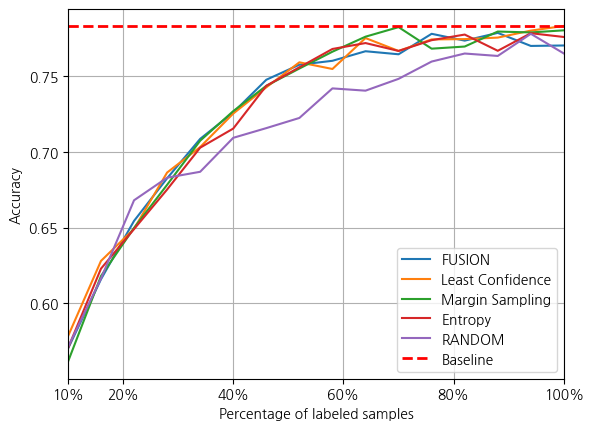

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(np.arange(10, 101, 6), acc_hist_FUSION, label="FUSION")
plt.plot(np.arange(10, 101, 6), acc_hist_LC, label="Least Confidence")
plt.plot(np.arange(10, 101, 6), acc_hist_MS, label="Margin Sampling")
plt.plot(np.arange(10, 101, 6), acc_hist_EN, label="Entropy")
plt.plot(np.arange(10, 101, 6), acc_hist_RN, label="RANDOM")
plt.hlines(y=baseline, xmin=10, xmax=100, label="Baseline", linestyles="--", linewidth=2, color="red")
tick = [10]+list(np.arange(20, 101, 20))
plt.xticks(tick)
ax.set_xticklabels([str(t)+"%" for t in tick])
plt.margins(x=0)

# plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Percentage of labeled samples")

# plt.legend(["Least Confidence", "Margin Sampling", "Entropy", "RANDOM", "Baseline"], loc="best")
plt.legend()
plt.grid()
plt.show()

In [ ]:
result = {"acc_hist_FUSION": acc_hist_FUSION, "acc_hist_LC": acc_hist_LC, "acc_hist_MS": acc_hist_MS, "acc_hist_EN": acc_hist_EN, "acc_hist_RN": acc_hist_RN, "seed": random_seed, "delta_0": 0.05}
import json

with open(f"result_{random_seed}_0.05.json", "w") as f:
    json.dump(result, f)

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 16/16 [18:59<00:00, 71.20s/it]


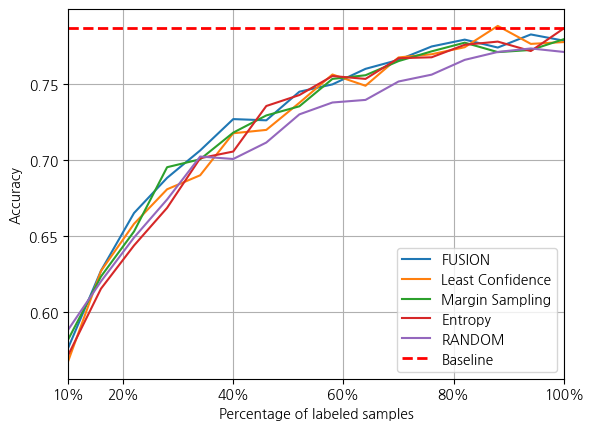

In [ ]:
acc_hist_FUSION = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="FUSION")
acc_hist_LC = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="LC")
acc_hist_MS = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="MS")
acc_hist_EN = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="EN")
acc_hist_RN = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="RN")

baseline = np.stack([acc_hist_EN, acc_hist_MS, acc_hist_LC, acc_hist_RN, acc_hist_FUSION])[:, -1].max()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(np.arange(10, 101, 6), acc_hist_FUSION, label="FUSION")
plt.plot(np.arange(10, 101, 6), acc_hist_LC, label="Least Confidence")
plt.plot(np.arange(10, 101, 6), acc_hist_MS, label="Margin Sampling")
plt.plot(np.arange(10, 101, 6), acc_hist_EN, label="Entropy")
plt.plot(np.arange(10, 101, 6), acc_hist_RN, label="RANDOM")
plt.hlines(y=baseline, xmin=10, xmax=100, label="Baseline", linestyles="--", linewidth=2, color="red")
tick = [10]+list(np.arange(20, 101, 20))
plt.xticks(tick)
ax.set_xticklabels([str(t)+"%" for t in tick])
plt.margins(x=0)

# plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Percentage of labeled samples")

# plt.legend(["Least Confidence", "Margin Sampling", "Entropy", "RANDOM", "Baseline"], loc="best")
plt.legend()
plt.grid()
plt.show()

In [ ]:
result = {"acc_hist_FUSION": acc_hist_FUSION, "acc_hist_LC": acc_hist_LC, "acc_hist_MS": acc_hist_MS, "acc_hist_EN": acc_hist_EN, "acc_hist_RN": acc_hist_RN, "seed": random_seed, "delta_0": 0.05}
import json

with open(f"result_{random_seed}_none.json", "w") as f:
    json.dump(result, f)